## Quelle: V Kishore Ayyadevara and Yeshwanth Reddy, Modern Computer Vision with PyTorch

In [46]:
import torch
import numpy as np
import cv2
import pandas as pd
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import cv2
from tqdm import tqdm

from time import sleep

import platform
print(f"MACHINE: {platform.machine()}")
print(f"PYTHON VERSION: {platform.python_version()}")
print(platform)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

MACHINE: AMD64
PYTHON VERSION: 3.10.6
<module 'platform' from 'C:\\Users\\annes\\AppData\\Local\\Programs\\Python\\Python310\\lib\\platform.py'>
device: cuda


In [ ]:
# DOWNLOAD DER DATEN:
# https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86

In [47]:
trn_df = pd.read_csv('C:/Users/annes/Desktop/cv2/fairface_label_train.csv')
val_df = pd.read_csv('C:/Users/annes/Desktop/cv2/fairface_label_val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [48]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    
    def __getitem__(self, ix):
        f = self.df.iloc[ix]
        file = f['file']
        gen = f['gender'] == 'Female'
        age = f['age']
        im = cv2.imread("istockphoto-1200677760-612x612.jpg")
        if im is None:
            raise ValueError(f"Failed to load image: {file}")
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gen

    def preprocess_image(self, im):
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im[None]

    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)

        # Handle age range or non-numeric values
            if '-' in age:  # If it's a range
                age_range = age.split('-')
                age_value = (int(age_range[0]) + int(age_range[1])) / 2
            elif age.isdigit():  # If it's a single numeric value
                age_value = int(age)
            else:
            # Handle non-numeric values (e.g., 'more than 70')
                if 'more than' in age:
                    age_value = 75  # Set a maximum age
                else:
                    age_value = 0  # Default age value (you can adjust this as needed)


            ages.append(float(age_value) / 80)
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)
        
        return ims, ages, genders

In [49]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

In [50]:
train_loader = DataLoader(trn, batch_size=64, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=64, collate_fn=val.collate_fn)
a,b,c, = next(iter(train_loader))
print(a.shape, b.shape, c.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64])


In [51]:
def get_model():

    
    #model = models.vgg16( weights='IMAGENET1K_V1' )  # oder 'VGG16_Weights.DEFAULT'
    model = models.vgg16(weights='IMAGENET1K_V1').to(device).float()

    print(model)
    
    summary(model, input_size=(3,224,224), device=device)
    
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
        
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.classifier = ageGenderClassifier()
    
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
    
    return model.to(device), loss_functions, optimizer

model, loss_functions, optimizer = get_model()

summary(model, input_size=(3,224,224), device=device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [52]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)    
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
      pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_acc, age_mae

In [53]:
model, criteria, optimizer = get_model()
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 5
best_test_loss = 1000
start = time.time()

for epoch in range(n_epochs):
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            loss = train_batch(data, model, optimizer, criteria)
            epoch_train_loss += loss.item() 
            sleep(0.1)

    for ix, data in enumerate(test_loader):
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        ctr += len(data[0])

    val_age_mae /= ctr
    val_gender_acc /= ctr
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)

    elapsed = time.time()-start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
    info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'
    print(info)

    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 0: 100%|██████████| 1355/1355 [14:09<00:00,  1.60batch/s]


1/5 (937.87s - 4689.36s remaining)
Epoch: 001	Train Loss: 0.851	Test: 0.849	Best Test Loss: 0.8495
Gender Accuracy: 52.88%	Age MAE: 10.10



Epoch 1: 100%|██████████| 1355/1355 [14:14<00:00,  1.58batch/s]


2/5 (1881.93s - 3763.86s remaining)
Epoch: 002	Train Loss: 0.849	Test: 0.851	Best Test Loss: 0.8495
Gender Accuracy: 52.88%	Age MAE: 10.18



Epoch 2: 100%|██████████| 1355/1355 [14:07<00:00,  1.60batch/s]


3/5 (2817.62s - 2817.62s remaining)
Epoch: 003	Train Loss: 0.849	Test: 0.850	Best Test Loss: 0.8495
Gender Accuracy: 52.88%	Age MAE: 10.13



Epoch 3: 100%|██████████| 1355/1355 [14:12<00:00,  1.59batch/s]


4/5 (3758.05s - 1879.02s remaining)
Epoch: 004	Train Loss: 0.849	Test: 0.850	Best Test Loss: 0.8495
Gender Accuracy: 52.88%	Age MAE: 10.14



Epoch 4: 100%|██████████| 1355/1355 [14:19<00:00,  1.58batch/s]


5/5 (4707.47s - 941.49s remaining)
Epoch: 005	Train Loss: 0.848	Test: 0.848	Best Test Loss: 0.8478
Gender Accuracy: 52.88%	Age MAE: 10.00



In [54]:
torch.save( model.state_dict(), 'ageGenderPrediction.pt' )

In [55]:
model, _, _ = get_model()
model.load_state_dict( torch.load('ageGenderPrediction.pt') )
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

predicted gender: Male ; Predicted age 27


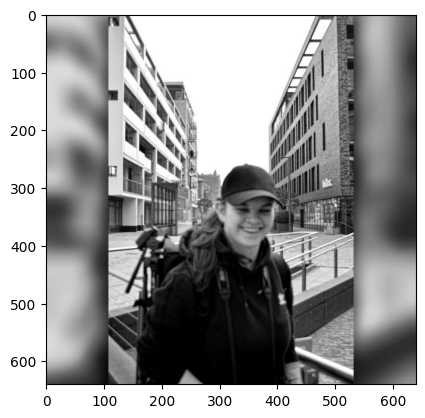

In [92]:
#!wget https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
#
im = cv2.imread('IMG_0764.JPG')
im = trn.preprocess_image(im).to(device)
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
im = cv2.imread('IMG_0764.JPG')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'), '; Predicted age', int(pred_age[0][0]*80))